In [3]:
import math
import time
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from itertools import product, combinations
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from collections import defaultdict



# -----------------------------------------------------------------------------
# Basic settings
# -----------------------------------------------------------------------------
block_qubits_num = 2  # num of qubits in block (example)
block_dim = 2**block_qubits_num  # also num of occpumational numbers
t_factor = 6          # extension multiplier (example)
basis_dim = math.comb(block_dim + t_factor - 1, block_dim - 1)  # basis dimentions in bosonic system


def one_qubit_operator_X_Z(angle=np.pi / 4):
    """
    Generates a mixture of Pauli-X and Pauli-Z operators on a single qubit.

    Parameters:
        angle (float): The angle parameterizing the mixture. Default is π/4.

    Returns:
        np.ndarray: A 2x2 matrix representing the operator.
    """
    if not isinstance(angle, (int, float)):
        raise ValueError("angle must be a numeric value.")
    return np.array([[np.sin(angle), np.cos(angle)],
                     [np.cos(angle), -np.sin(angle)]])


def plot_colormap(array):
    """
    Plot a 2D array as a colormap.
    Parameters:
        array (list of lists or numpy array)
    """
    array = np.array(array)
    fig, ax = plt.subplots()
    cax = ax.imshow(array, cmap='viridis')
    fig.colorbar(cax)
    plt.show()

def opnorm_inf(H: np.ndarray) -> float:
    # spectral norm; for Hermitian equals max|eig|
    if np.allclose(H, H.conj().T):
        return float(np.max(np.abs(np.linalg.eigvalsh(H))))
    return float(np.linalg.svd(H, compute_uv=False).max())

def normalize_single_copy(H: np.ndarray):
    s = opnorm_inf(H)
    return (H / s if s > 0 else H), (s if s > 0 else 1.0)

# {I,X,Y,Z}x{I,X,Y,Z}={I,IX,IY,IZ,XI,XY,XZ,YI,YX,YY,YZ,ZI,ZX,ZY,ZZ} simpler if real only
# Pauli bases
I = np.eye(2, dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
CP = np.diag([1, 1, 1, -1])

pool_1q = ["I", "X", "Y", "Z"]
all_matrices_keys = [i + j for i in pool_1q for j in pool_1q]
pool_1q = [I, X, Y, Z]
M = dict.fromkeys(all_matrices_keys + ["CP"], 0)
pool_2q = [np.kron(i, j) for i in pool_1q for j in pool_1q]
pool_2q.append(CP)
a = 0
for k in M.keys():
    M[k] = pool_2q[a]
    a += 1


# working with bosonic basis
def global_basis_states(multipl=t_factor, block=block_dim, dictionary=False):
    """
    Generates a list of bosonic states for a given number of qubits and multiplier.

    Parameters:
        multipl (int): The multiplier (t_embedding). Default is t_factor.
        block (int): The number of qubits. Default is block_dim.
        dictionary (bool): If True, returns a dictionary with states as keys. Default is False.

    Returns:
        list or tuple: A list of compositions or a tuple (compositions, dictionary).
    """
    bars = combinations(range(multipl + block - 1), block - 1)

    compositions = []
    for bar in bars:
        bar_positions = [-1] + list(bar) + [multipl + block - 1]
        composition = tuple(bar_positions[i + 1] - bar_positions[i] - 1 for i in range(block))
        compositions.append(composition)

    compositions.reverse()

    if dictionary:
        return compositions, dict.fromkeys(compositions, 0)
    return compositions

def one_qubit_stabilizers():
    z0 = np.array([1,0], dtype=complex)
    z1 = np.array([0,1], dtype=complex)
    xp = (z0+z1)/np.sqrt(2); xm = (z0-z1)/np.sqrt(2)
    yp = (z0+1j*z1)/np.sqrt(2); ym = (z0-1j*z1)/np.sqrt(2)
    return [z0,z1,xp,xm,yp,ym]

def two_qubit_stabilizer_states():
    paulis = [I,X,Y,Z]
    twopaulis = [np.kron(a,b) for a in paulis for b in paulis]
    twopaulis = [P for P in twopaulis if not np.allclose(P, np.eye(4))]
    states = []
    seen = set()
    Id4 = np.eye(4, dtype=complex)
    for i in range(len(twopaulis)):
        P1 = twopaulis[i]
        for j in range(i+1, len(twopaulis)):
            P2 = twopaulis[j]
            if not np.allclose(P1@P2, P2@P1): 
                continue
            # +1 eigenspace projector
            P = (Id4 + P1)/2 @ (Id4 + P2)/2
            A = (P + P.conj().T)/2
            w, V = np.linalg.eigh(A)
            k = int(np.argmax(w))
            if w[k] > 1-1e-9:  # rank-1
                psi = V[:,k] / np.linalg.norm(V[:,k])
                rho = np.outer(psi, psi.conj())
                key = (np.round(rho.real,8).tobytes(), np.round(rho.imag,8).tobytes())
                if key not in seen:
                    seen.add(key); states.append(psi)
    return states  # should be 60

def s_stab_singlecopy(W1: np.ndarray, n_qubits: int) -> float:
    if n_qubits == 1:
        S = one_qubit_stabilizers()
        return max(np.real(np.vdot(psi, W1 @ psi)) for psi in S)
    elif n_qubits == 2:
        S = two_qubit_stabilizer_states()
        return max(np.real(np.vdot(psi, W1 @ psi)) for psi in S)
    else:
        raise NotImplementedError("Only n=1,2 stabilizer enumeration provided.")

def aidaj(index1, index2, vector):
    """
    Action of the operator (a_i^\dagger)(a_j) on a given vector.

    Parameters:
        index1 (int): The index for the creation operator.
        index2 (int): The index for the annihilation operator.
        vector (tuple or list): The input vector.

    Returns:
        tuple: A tuple containing the new vector and the coefficient.
    """
    # Input validation
    if not isinstance(vector, (tuple, list)):
        raise TypeError("vector must be a tuple or list.")
    if not all(isinstance(x, int) for x in vector):
        raise TypeError("All elements of vector must be integers.")
    if index1 >= len(vector) or index2 >= len(vector) or index1 < 0 or index2 < 0:
        raise ValueError("Indices out of range.")

    # If the annihilation operator acts on a zero element, return the original vector and zero coefficient
    if vector[index2] == 0:
        return vector, 0

    # Compute the new vector and coefficient
    v = list(vector)
    c = np.sqrt(v[index2])
    v[index2] -= 1
    c *= np.sqrt(v[index1] + 1)
    v[index1] += 1

    return tuple(v), c


def build_embedded_matrix(H, block_dim=2, size=6):
    """
    Constructs an embedded matrix from a given operator H in a bosonic basis.

    Parameters:
        H (np.ndarray): Matrix of size block_dim x block_dim.
        block_dim (int): The dimension of the matrix. Default is 2.
        size (int): The scale parameter for the bosonic basis. Default is 6.

    Returns:
        np.ndarray: The embedded matrix of size basis_dim x basis_dim.
    """
    if not isinstance(H, np.ndarray) or H.shape != (block_dim, block_dim):
        raise ValueError("H must be a square matrix of size block_dim x block_dim.")
    if not isinstance(size, int) or size <= 0:
        raise ValueError("size must be a positive integer.")

    basis_dim_local = math.comb(block_dim + size - 1, block_dim - 1)
    basis, _ = global_basis_states(multipl=size, block=block_dim, dictionary=True)
    H, _ = normalize_single_copy(H)
    embedded = np.zeros((basis_dim_local, basis_dim_local), dtype=np.complex128)

    for k in range(basis_dim_local):
        vector = dict.fromkeys(basis, 0)
        for i in range(block_dim):
            for j in range(block_dim):
                if H[i][j] != 0:
                    new_state, coeff = aidaj(i, j, basis[k])
                    vector[new_state] += coeff * H[i][j]
        for l in range(basis_dim_local):
            embedded[k][l] = vector[basis[l]]
    return embedded / size


# support structures for antiidentity operations:
def reference_binary(block_size=block_qubits_num):
    """
    Generates a reference matrix and vocabulary for all possible binary states of a given number of qubits.

    Parameters:
        block_size (int): The number of qubits. Default is block_qubits_num.

    Returns:
        tuple: (ref_matrix, ref_vocab)
    """
    if not isinstance(block_size, int) or block_size <= 0:
        raise ValueError("block_size must be a positive integer.")

    num_states = 2**block_size
    binary_states = [tuple(int(bit) for bit in bin(i)[2:].zfill(block_size)) for i in range(num_states)]
    ref_matrix = np.array(binary_states)
    ref_vocab = {state: idx for idx, state in enumerate(binary_states)}
    return ref_matrix, ref_vocab


def swapper(obj, reference, reference_vec):
    """
    Performs a swapping operation on the input object based on a reference matrix and vocabulary.

    Parameters:
        obj (list or tuple): The input object.
        reference (np.ndarray): The reference matrix.
        reference_vec (dict): A dictionary mapping binary states to their indices.

    Returns:
        tuple: The swapped object.
    """
    swp_indx = []
    output = []
    length = len(obj)
    width = len(reference[0])

    for j in range(width):
        swp_indx.append(0)
        for i in range(length):
            swp_indx[j] += obj[i] * reference[i][j]
        swp_indx[j] %= 2

    for i in range(length):
        temp = reference[i].copy()
        for j in range(width):
            temp[j] = (swp_indx[j] + temp[j]) % 2
        output.append(obj[reference_vec[tuple(temp)]])
    return tuple(output)


def AnId_lesdim_1(obj, reference, reference_vec, AId_dim=6, t_factor=6):
    """
    Computes the action of a specific-dimension anti-identity operation on the input object.

    Parameters:
        obj (list or tuple): The input object.
        reference (np.ndarray): The reference matrix.
        reference_vec (dict): A dictionary mapping binary states to their indices.
        AId_dim (int or str): The dimensionality of the anti-identity operation. Default is "Max".
        t_factor (int): The size parameter for the bosonic basis. Default is t_factor.

    Returns:
        list: A list of transformed objects.
    """
    # input check
    if AId_dim % 6 != 0 and AId_dim > 0:
        raise TypeError("Antiidentity generator dimension must be positive multiples of 6")
    if t_factor < AId_dim:
        raise TypeError("Antiidentity generator dimension must not be larger then number of copies")
    counter2 = 0
    for x in obj:
        if x < 0:
            raise TypeError("negative values in object")
        counter2 += x
    if counter2 != t_factor:
        raise TypeError("wrong object: wrong number of entries detected")

    variants = list(combinations(range(t_factor), AId_dim))
    output = []

    for comb in variants:
        restrained_vector = np.zeros_like(obj)
        counter1 = 0
        counter2 = 0

        for i in range(len(obj)):
            for _ in range(obj[i]):
                if counter1 == comb[counter2]:
                    counter2 += 1
                    restrained_vector[i] += 1
                    if counter2 >= AId_dim:
                        break
                counter1 += 1
            if counter2 >= AId_dim:
                break

        counter2 = 0
        for i in range(len(obj)):
            for _ in range(obj[i]):
                counter2 += 1
        if counter2 != t_factor:
            raise TypeError("wrong object: wrong number of entries detected")

        swapped_vector = list(swapper(restrained_vector, reference=reference, reference_vec=reference_vec))
        result = tuple(np.array(obj) - restrained_vector + swapped_vector)
        output.append(result)

    return set(output)


def multinomial_coeff(a):
    """
    computes a multinomial coefficient (number of computational states mixed in bosonic state)

    Parameter:
        a (tuple, int): bosonic basis state.

    Returns:
        integer: coefficient
    """
    T = sum(a)
    log_coeff = math.lgamma(T + 1)  # ln(T!)
    for num in a:
        log_coeff -= math.lgamma(num + 1)  # Subtract ln(num!)
    return round(math.exp(log_coeff))  # Convert back to integer


def orbit_counting(t_multiplier=t_factor, qubit_num=block_qubits_num, AnId_dim_set=[6], verbose=True, only_orbits=False):
    """
    Constructs orbits induced by anti-identities of specified set of dimensions, creates a conversion matrix.

    Parameters:
        t_multiplier (int): The size parameter for the bosonic basis. Default is t_factor.
        qubit_num (int): The number of qubits. Default is block_qubits_num.
        AnId_dim_set (list): A list of dimensions for the anti-identity operations. Default is ["Max"].
        verbose (bool): If True, prints progress information. Default is True.

    Returns:
        tuple:
            - orbits (dict): A dictionary mapping orbit numbers to sets of basis states.
            - basis_orbit_index (list): A list mapping basis states to orbit numbers.
            - basis (list): The list of basis states.
            - basis_dict (dict): A dictionary mapping basis states to their indices.
            - conversion_matrix (np.ndarray): The conversion matrix for transforming to the reduced basis.
    """
    block = 2**qubit_num
    basis, basis_dict = global_basis_states(t_multiplier, block, True)
    for i in range(len(basis)):
        basis_dict[basis[i]] = i

    reference_matrix, reference_vector = reference_binary(block_size=qubit_num)

    basis_orbit_index = [-1] * len(basis)
    basis_state_weight = np.zeros(len(basis))  # !!!!#
    orbits = {}
    orbit_number = 0
    inorbits = set()
    current = 0

    if verbose:
        print("orbit counting for ", t_multiplier, "copies, of ", qubit_num, "qubits")
    progress = tqdm(desc="counting...", unit="step", total=len(basis), mininterval=1, disable=not verbose)

    while current < len(basis):
        if current in inorbits:
            current += 1
            continue

        q = {current}
        newq = set(q)

        while len(newq) > 0:
            qq = set(newq)
            newq = set()
            for i in qq:
                for aiid in AnId_dim_set:
                    A = AnId_lesdim_1(
                        basis[i],
                        reference=reference_matrix,
                        reference_vec=reference_vector,
                        AId_dim=aiid,
                        t_factor=t_multiplier,
                    )
                    for j in A:
                        tem = basis_dict[j]
                        if tem not in q:
                            newq.add(tem)
            q.update(newq)

        inorbits.update(q)
        orbits.update({orbit_number: q})
        for y in q:
            basis_orbit_index[y] = orbit_number

        current += 1
        orbit_number += 1
        progress.update(len(q))
    progress.close()
    if only_orbits: 
        print( "new basis dim =", len(orbits), "/ old basis dim :",len(basis) )
        return orbits, basis_orbit_index
    # create conversion matrix
    state_weights = np.zeros(len(basis))  # weights in orbits vector for bosonic states
    for orbi in orbits:  # going over all orbits
        orbit_weight = 0  # total orbit weight reset
        for j in orbits[orbi]:  # going over all bosonic states in the current orbit
            state_weights[j] = multinomial_coeff(basis[j])      # initial weight
            orbit_weight += state_weights[j]
        for j in orbits[orbi]:
            state_weights[j] = np.sqrt(state_weights[j] / orbit_weight)

    conversion_matrix = np.zeros((len(orbits), len(basis)))
    for i in range(len(basis)):
        conversion_matrix[basis_orbit_index[i]][i] = state_weights[i]

    if verbose:
        print("new basis dim =", len(conversion_matrix), "/ old basis dim :", len(conversion_matrix[0])) 

    return orbits, basis_orbit_index, basis, basis_dict, conversion_matrix


def reduce_embedded(embedded_matrix, conversion_matrix):
    """
    Converts an embedded matrix to a reduced basis using a conversion matrix.

    Parameters:
        embedded_matrix (np.ndarray): The embedded matrix to be reduced.
        conversion_matrix (np.ndarray): The conversion matrix for the basis transformation.

    Returns:
        np.ndarray: The reduced matrix.
    """
    if not isinstance(embedded_matrix, np.ndarray) or len(embedded_matrix.shape) != 2:
        raise TypeError("embedded_matrix must be a 2D numpy array.")
    if not isinstance(conversion_matrix, np.ndarray) or len(conversion_matrix.shape) != 2:
        raise TypeError("conversion_matrix must be a 2D numpy array.")
    if embedded_matrix.shape[1] != conversion_matrix.shape[1]:
        raise ValueError("The number of columns in embedded_matrix must match the number of columns in conversion_matrix.")

    identity_check = conversion_matrix @ np.transpose(conversion_matrix)
    identity_matrix = np.eye(len(identity_check))
    if not np.allclose(identity_check, identity_matrix, atol=1e-5):
        raise ValueError("The conversion matrix is not orthogonal.")
    reduced_matrix = conversion_matrix @ embedded_matrix @ np.transpose(conversion_matrix)
    return reduced_matrix


def Convex_problem_run(
    initstate,
    block_qubits=block_qubits_num,
    multiplier=t_factor,
    Verbose=False,
    Antiid_dim_set=[6],
    canon_backend=cp.SCIPY_CANON_BACKEND,
    solver=cp.SCS,
    complexity=True,
):
    """
                        << Convex optimization problem >>

    Parameters:
        initstate (np.ndarray): initial operator
        block_qubits (int): The number of qubits in a block. Default is block_qubits_num.
        multiplier (int): The scaling parameter the bosonic basis. Default is t_factor.
        Verbose (bool): If True, prints progress information. Default is False.
        Antiid_dim_set (list): A list of dimensions for the anti-identity. Default is [6].
        canon_backend: The canonicalization backend for cvxpy. Default is cp.SCIPY_CANON_BACKEND.
        solver: The solver for cvxpy. Default is cp.SCS.
        complexity (bool): If True, uses complex-valued variables. Default is True.

    Returns:
        ---------
    """
    start = time.time()

    # Perform orbit counting
    orbits, basis_orbit_index, basis, basis_dict, conversion_matrix = orbit_counting(
        t_multiplier=multiplier, qubit_num=block_qubits, AnId_dim_set=Antiid_dim_set, verbose=Verbose
    )

    # Build and reduce the embedded matrix
    embedded_matrix = build_embedded_matrix(initstate, block_dim=2**block_qubits, size=multiplier)
    reduced_embedded_matrix = reduce_embedded(embedded_matrix, conversion_matrix=conversion_matrix)

    # Set up the convex optimization problem
    if complexity and Verbose:
        print("solving with complex values")

    if complexity:
        current_var = cp.Variable((len(orbits), len(orbits)), hermitian=True)
        constraints = [cp.trace(current_var) == 1, current_var >> 0]
        objective = cp.real(cp.trace(reduced_embedded_matrix @ current_var))
    else:
        current_var = cp.Variable((len(orbits), len(orbits)), PSD=True)
        constraints = [cp.trace(current_var) == 1]
        # Avoid cp.real on a real expression in CVXPY
        objective = cp.trace(reduced_embedded_matrix @ current_var)

    prob = cp.Problem(cp.Maximize(objective), constraints)
    setup_time = time.time() - start

    sol = prob.solve(canon_backend=canon_backend, solver=solver, verbose=Verbose)
    end_time = time.time()

    if Verbose:
        print(f"Total time: {end_time - start} s (setup: {setup_time} s; solver call: {end_time - start - setup_time} s)")
        print(f"Optimal value: {sol}")
        print(f"Trace of reduced embedded matrix: {np.trace(reduced_embedded_matrix)}")

    return (
        sol,
        current_var.value,
        np.linalg.norm(current_var.value),
        np.linalg.norm(reduced_embedded_matrix),
        np.linalg.norm(reduced_embedded_matrix, ord=2),
    )


def split_convex_setup(
    block_qubits=block_qubits_num,
    multiplier=t_factor,
    Verbose=False,
    Antiid_dim_set=[6],
    canon_backend=cp.SCIPY_CANON_BACKEND,
    solver=cp.SCS,
    complexity=True,
):
    """
    Sets up a convex optimization problem for a given number of qubits and multiplier.

    Parameters:
        block_qubits (int): The number of qubits in a block. Default is block_qubits_num.
        multiplier (int): The size parameter for the bosonic basis. Default is t_factor.
        Verbose (bool): If True, prints progress information. Default is False.
        Antiid_dim_set (list): A list of dimensions for the anti-identity operations. Default is [6].
        canon_backend: The canonicalization backend for cvxpy. Default is cp.SCIPY_CANON_BACKEND.
        solver: The solver for cvxpy. Default is cp.SCS.
        complexity (bool): If True, uses complex-valued variables. Default is True.

    Returns:
        orbits (dict)
        conversion_matrix (np.ndarray)
        prob (cp.Problem)
        reduced_embedded_matrix (cp.Parameter)
        current_var (cp.Variable)
        basis (list of tuples)
        basis_dict (dict)
    """
    block = 2**block_qubits

    # Orbit counting:
    orbits, _, basis, basis_dict, conversion_matrix = orbit_counting(
        t_multiplier=multiplier, qubit_num=block_qubits, AnId_dim_set=Antiid_dim_set, verbose=Verbose
    )

    reduced_embedded_matrix = cp.Parameter((len(orbits), len(orbits)), hermitian=True)

    if complexity:
        current_var = cp.Variable((len(orbits), len(orbits)), hermitian=True)
        constraints = [cp.trace(current_var) == 1, current_var >> 0]
        objective = cp.real(cp.trace(reduced_embedded_matrix @ current_var))
    else:
        current_var = cp.Variable((len(orbits), len(orbits)), PSD=True)
        constraints = [cp.trace(current_var) == 1]
        # Avoid cp.real on a real expression in CVXPY
        objective = cp.trace(reduced_embedded_matrix @ current_var)

    prob = cp.Problem(cp.Maximize(objective), constraints)

    return orbits, conversion_matrix, prob, reduced_embedded_matrix, current_var, basis, basis_dict


def split_convex_run(
    initstate,
    conversion_matrix,
    problemo,
    parametero,
    variableo,
    block_qubits=block_qubits_num,
    multiplier=t_factor,
    Verbose=False,
    canon_backend=cp.SCIPY_CANON_BACKEND,
    solver=cp.SCS,
):
    """
    Runs a pre-setup convex optimization problem for a given initial matrix.

    Parameters:
        initstate (np.ndarray): The initial state vector.
        conversion_matrix (np.ndarray): The conversion matrix for the basis transformation.
        problemo (cp.Problem): The convex optimization problem.
        parametero (cp.Parameter): The parameter for the reduced embedded matrix.
        variableo (cp.Variable): The optimization variable.
        block_qubits (int): The number of qubits in a block. Default is block_qubits_num.
        multiplier (int): The size parameter for the bosonic basis. Default is t_factor.
        Verbose (bool): If True, prints progress information. Default is False.
        canon_backend: The canonicalization backend for cvxpy. Default is cp.SCIPY_CANON_BACKEND.
        solver: The solver for cvxpy. Default is cp.SCS.

    Returns:
        tuple: (sol, var_value)
    """
    block = 2**block_qubits
    embedded_matrix = build_embedded_matrix(initstate, block_dim=block, size=multiplier)
    reduced_embedded_matrix = reduce_embedded(embedded_matrix, conversion_matrix=conversion_matrix)
    # enforce Hermitian (solver tolerances can introduce tiny skew-Hermitian parts)
    reduced_embedded_matrix = 0.5 * (reduced_embedded_matrix + reduced_embedded_matrix.conj().T)
    parametero.value = reduced_embedded_matrix
    sol = problemo.solve(canon_backend=canon_backend, solver=solver, eps=1e-6, max_iters=20000, verbose=Verbose)

    if Verbose:
        print(f"Optimal value: {sol}")
        print(f"Trace of reduced embedded matrix: {np.trace(reduced_embedded_matrix)}")

    return sol, variableo.value


def construct_reduced_density_2(reduced_post_orbital, conversion_matrix, basis, basis_dict, copies):
    """
    Computes the reduced density matrix for one subsystem from the density matrix in the reduced basis.

    Parameters:
        rho_reduced (np.ndarray): The density matrix in the reduced basis.
        conversion_matrix (np.ndarray): The conversion matrix from orbit counting.
        basis (np.ndarray or list of tuples): Bosonic occupation number basis.
        basis_dict : dictionary of basis states.
        copies (int, >0): Number of copies, (i.e. numper of particles)

    Returns:
        np.ndarray: The reduced density matrix for one subsystem.
    """
    rho = conversion_matrix.conj().T @ reduced_post_orbital @ conversion_matrix
    rho = 0.5 * (rho + rho.conj().T)

    trace_rho = np.trace(rho)
    if not np.isclose(trace_rho, 1.0):
        raise ValueError("rho is not properly normalized. Trace is not 1.")

    dim_full = len(basis)
    dim_reduced = len(basis[0])
    rho_1 = np.zeros((dim_reduced, dim_reduced), dtype=complex)

    # compute matrices of creation and anihilation operators:
    a_i_dag_a_j = np.zeros((dim_reduced, dim_reduced, dim_full, dim_full))
    for i in range(dim_reduced):
        for j in range(dim_reduced):
            for vector in basis:
                new_vector, coeff = aidaj(i, j, vector)
                a_i_dag_a_j[i][j][basis_dict[vector]][basis_dict[new_vector]] = coeff
    # normalization
    a_i_dag_a_j *= (1 / copies)

    # computing 1-rdm
    for i in range(dim_reduced):
        for j in range(dim_reduced):
            rho_1[i][j] = np.trace(rho @ a_i_dag_a_j[j][i])

    trrho = np.trace(rho_1)
    if not np.isclose(trrho, 1.0):
        raise ValueError("rho_1 is not properly normalized. Trace is not 1.")
    return rho_1


#just renaming
def multinomial_coeff_int(a):
    return multinomial_coeff(a)

#use teh balls & bins logic to define functions faster
def AnId_restrict_occup(obj, choose_idx):
    # take occupancy vector -> restricted occupancy with ones at choose_idx
    t = sum(obj); k = len(choose_idx)
    res = [0] * len(obj)
    # map positions 0..t-1 to bins of obj
    pos = 0; ptr = 0
    choose_idx = list(choose_idx)
    for i, c in enumerate(obj):
        end = pos + c
        # count how many choose_idx fall in [pos,end)
        while ptr < len(choose_idx) and choose_idx[ptr] < pos:
            ptr += 1
        c_here = 0
        while ptr < len(choose_idx) and choose_idx[ptr] < end:
            c_here += 1; ptr += 1
        res[i] = c_here
        pos = end
    assert sum(res) == k
    return tuple(res)

def build_perm_maps(t_factor: int, block_qubits: int, AId_dim: int):
    # one map per comb; each map is an array of length |basis|
    block_dim = 2**block_qubits
    basis, _tmp = global_basis_states(multipl=t_factor, block=block_dim, dictionary=True)
    basis_dict = {v: i for i, v in enumerate(basis)}
    N = len(basis)
    refM, refV = reference_binary(block_size=block_qubits)
    maps = []
    for comb in combinations(range(t_factor), AId_dim):
        out = np.empty(N, dtype=int)
        for idx, v in enumerate(basis):
            restr = AnId_restrict_occup(v, comb)
            swapped = swapper(restr, reference=refM, reference_vec=refV)
            new_v = tuple(np.array(v) - np.array(restr) + np.array(swapped))
            out[idx] = basis_dict[new_v]
        maps.append(out)
    return maps, basis, basis_dict

def compositions_k_into_d(k, d):
    if d == 1:
        return [(k,)]
    out = []
    def rec(prefix, rem, slots):
        if slots == 1:
            out.append(tuple(prefix + [rem])); return
        for x in range(rem + 1):
            rec(prefix + [x], rem - x, slots - 1)
    rec([], k, d)
    return out

def build_perm_maps_compositions(t_factor: int, block_qubits: int, AId_dim: int):
    block_dim = 2**block_qubits
    basis, _tmp = global_basis_states(multipl=t_factor, block=block_dim, dictionary=True)
    basis_dict = {v: i for i, v in enumerate(basis)}
    N = len(basis)
    refM, refV = reference_binary(block_size=block_qubits)

    Rs = compositions_k_into_d(AId_dim, block_dim)  # count-vectors r s.t. sum r_i = AId_dim
    maps = []
    for r in Rs:
        r = np.array(r, dtype=int)
        # parity flip per Pauli label induced by r
        swp = (refM.T @ r) % 2
        perm = np.empty(block_dim, dtype=int)
        for lbl, row in enumerate(refM):
            out_bits = tuple((row + swp) % 2)
            perm[lbl] = refV[out_bits]

        out = np.arange(N, dtype=int)
        for idx, v in enumerate(basis):
            v = np.array(v, dtype=int)
            if np.any(r > v):  # cannot choose this r
                continue
            swapped = np.zeros_like(v)
            # move r[lbl] quanta from label lbl to perm[lbl]
            for lbl, count in enumerate(r):
                if count:
                    swapped[perm[lbl]] += count
            new_v = v - r + swapped
            out[idx] = basis_dict[tuple(new_v)]
        maps.append(out)
    return maps, basis, basis_dict

def orbit_counting_fast(t_factor: int,
                        block_qubits: int,
                        AId_dim_set=[6],
                        verbose: bool=True,
                        orbits_only: bool=False):
    """
    Faster: no global map list. For each basis state, apply AId once per k and
    union with all images returned by AnId_lesdim_1. Peak memory ~O(B), B=|basis|.
    """
    d = 2**block_qubits
    # bosonic basis and lookup
    basis, basis_dict = global_basis_states(t_factor, d, dictionary=True)
    refM, refV = reference_binary(block_size=block_qubits)
    d = 2**block_qubits
    basis, basis_dict = global_basis_states(t_factor, d, dictionary=True)
    # make basis_dict point to indices, not zeros!!!!
    for idx, b in enumerate(basis):
        basis_dict[b] = idx

    class DSU:
        def __init__(self, n):
            self.p = list(range(n)); self.r = [0]*n
        def find(self, x):
            while self.p[x] != x:
                self.p[x] = self.p[self.p[x]]; x = self.p[x]
            return x
        def union(self, a, b):
            ra, rb = self.find(a), self.find(b)
            if ra == rb: return
            if self.r[ra] < self.r[rb]: ra, rb = rb, ra
            self.p[rb] = ra
            if self.r[ra] == self.r[rb]: self.r[ra] += 1

    N = len(basis)
    dsu = DSU(N)

    # streaming unions, no dense maps kept in memory
    pb = tqdm(total=N*len(AId_dim_set),
              desc="AId unions (streaming)", unit="state",
              disable=not verbose,
              bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")
    for k in AId_dim_set:
        for i, occ in enumerate(basis):
            # set of images produced by AId on size-k block placements
            imgs = AnId_lesdim_1(occ, reference=refM, reference_vec=refV,
                                 AId_dim=k, t_factor=t_factor)
            # union i with each image index
            for occ2 in imgs:
                j = basis_dict[occ2]
                dsu.union(i, j)
            pb.update(1)
    pb.close()

    # components → orbit lists
    comps = defaultdict(list)
    for i in range(N):
        comps[dsu.find(i)].append(i)

    if orbits_only:
        if verbose:
            print(f"orbits: {len(comps)}  basis: {N}")
        return comps, basis, basis_dict, None

    # sparse conversion C with multinomial weights (orthonormal rows)
    # precompute log-factorials once for fast multinomials
    logfac = np.array([math.lgamma(k+1) for k in range(t_factor+1)], dtype=float)
    def multinomial_fast(v):
        s = logfac[t_factor]
        for x in v: s -= logfac[x]
        return math.exp(s)

    R = len(comps); rows = []; cols = []; data = []
    pb = tqdm(total=R, desc="Build C", unit="orbit",
              disable=not verbose,
              bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")
    for r, idxs in enumerate(comps.values()):
        w = np.fromiter((multinomial_fast(basis[j]) for j in idxs), float)
        w = np.sqrt(w / w.sum())
        rows += [r]*len(idxs); cols += idxs; data += w.tolist()
        pb.update(1)
    pb.close()

    C = csr_matrix((data, (rows, cols)), shape=(R, N))
    if verbose:
        print(f"orbits: {R}  basis: {N}")
    return comps, basis, basis_dict, C

def build_reduced_operator(H, C_csr, C_csc, basis, basis_dict, t_factor: int):
    # H is (d x d). Implement (1/t) * sum_{ij} H_{ij} a_i^† a_j, projected as C A C^T.
    R, _ = C_csr.shape
    d = H.shape[0]
    Hred = lil_matrix((R, R), dtype=complex if np.iscomplexobj(H) else float)

    for k, v in enumerate(basis):
        ck = C_csc.getcol(k)  # column of C for source
        for j, vj in enumerate(v):
            if vj == 0:
                continue
            sqrt_out = math.sqrt(vj)
            v_base = list(v); v_base[j] -= 1
            for i in range(d):
                hij = H[i, j]
                if hij == 0:
                    continue
                v_new = v_base.copy(); v_new[i] += 1
                l = basis_dict[tuple(v_new)]
                val = (hij * sqrt_out * math.sqrt(v_new[i])) / t_factor
                cl = C_csc.getcol(l)  # column of C for target
                Hred += val * (ck @ cl.T)
    return Hred.tocsr()

def precompute_Q(block_qubits: int, t_factor: int, C, basis, basis_dict):
    d = 2**block_qubits
    C_csr, C_csc = C.tocsr(), C.tocsc()
    Q = {}
    eye = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            E = eye.copy(); E[i, j] = 1.0
            Q[(i, j)] = build_reduced_operator(E, C_csr, C_csc, basis, basis_dict, t_factor)
    return Q

def reduced_from_Q(H, Q):
    d = H.shape[0]
    out = None
    for i in range(d):
        for j in range(d):
            hij = H[i, j]
            if hij == 0:
                continue
            out = Q[(i, j)] * hij if out is None else out + Q[(i, j)] * hij
    return out.tocsr()

def setup_reduced_sdp(R: int, complex_var: bool):
    if complex_var:
        X = cp.Variable((R, R), hermitian=True)
        Hpar = cp.Parameter((R, R), hermitian=True)
        obj = cp.real(cp.trace(Hpar @ X))
    else:
        X = cp.Variable((R, R), symmetric=True)
        Hpar = cp.Parameter((R, R))
        obj = cp.trace(Hpar @ X)  # no cp.real on a real expression
        # alternatively: obj = cp.sum(cp.multiply(Hpar, X))  # == trace(Hpar.T @ X)
    prob = cp.Problem(cp.Maximize(obj), [cp.trace(X) == 1, X >> 0])
    return prob, Hpar, X

# build once per (n_qubits, t)
def prepare_sweep_bases(M, Q):
    Hr = {}
    for key in ("XX", "XZ", "ZI", "YY", "YZ", "ZY"):  # compute what you need
        if key in M:
            Hr[key] = reduced_from_Q(M[key], Q).toarray()
    return Hr

def run_reduced(H, prob, Hpar, X, Q=None, C=None, basis=None, basis_dict=None, t_factor=None):
    if Q is not None:
        Hred = reduced_from_Q(H, Q)
    else:
        # fallback if Q not given
        Hred = build_reduced_operator(H, C.tocsr(), C.tocsc(), basis, basis_dict, t_factor)
    Hpar.value = Hred.toarray()
    val = prob.solve(solver=cp.SCS, eps=1e-4, max_iters=10000, verbose=False)
    return val, X.value

def rdm1_from_reduced(rho_red, Q, t_factor):
    # Q[(i,j)] already equals C (a_i^\dag a_j / t) C^T
    R = csr_matrix(rho_red)
    d = max(i for i, _ in Q.keys()) + 1
    rho1 = np.zeros((d, d), dtype=complex)
    for i in range(d):
        for j in range(d):
            rho1[i, j] = (Q[(j, i)].multiply(R)).sum()   # no extra / t
    return rho1

def check_C_orthonormal(C, atol=1e-8):
    I = (C @ C.T).toarray()
    return np.allclose(I, np.eye(I.shape[0]), atol=atol)

def check_objective_match(H, rho_red, C, basis, basis_dict, t_factor, Q, atol=1e-7):
    # rebuild Hred via Q and compare Tr(Hred rho_red) against full lift
    Hred = reduced_from_Q(H, Q)
    lhs = float(np.real((Hred.multiply(csr_matrix(rho_red))).sum()))
    # faster: reuse reduced build path
    Hred2 = build_reduced_operator(H, C.tocsr(), C.tocsc(), basis, basis_dict, t_factor)
    rhs = float(np.real((Hred2.multiply(csr_matrix(rho_red))).sum()))
    return abs(lhs - rhs) <= atol

def check_rdm_trace(rho1, atol=1e-8):
    return abs(np.trace(rho1) - 1.0) <= atol

def spectral_norm_preserved(H, Hred, atol=1e-7):
    sH = np.linalg.svd(H, compute_uv=False)[0]
    sR = np.linalg.svd(Hred.toarray(), compute_uv=False)[0]
    return abs(sH - sR) <= atol


# Magic assesment: trace gap + robustness (clean block)
# =========================================


# ---------- Pauli utilities ----------
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
_ONEQ = {'I':I,'X':X,'Y':Y,'Z':Z}

def _kron_all(mats):
    out = np.array([[1]], dtype=complex)
    for M in mats: out = np.kron(out, M)
    return out

def pauli_label_to_matrix(label):           # e.g. "XIZ"
    return _kron_all([_ONEQ[c] for c in label])

def all_pauli_labels(n):                    # includes all-I
    return [''.join(p) for p in product('IXYZ', repeat=n)]

def pauli_weight(label):                    # Hamming weight ignoring I
    return sum(c!='I' for c in label)

# ---------- Stabilizer enumeration (pure, n<=3, includes ± signs) ----------
def _xz_from_label(label):
    x = np.array([c in ('X','Y') for c in label], dtype=np.uint8)
    z = np.array([c in ('Z','Y') for c in label], dtype=np.uint8)
    return x, z

def _symp_commutes(x1,z1,x2,z2):
    return ((x1 & z2).sum() ^ (z1 & x2).sum()) % 2 == 0

def _gf2_rank(A):
    A = A.copy() % 2
    m,n = A.shape
    r = 0; c = 0
    while r < m and c < n:
        piv = None
        for i in range(r,m):
            if A[i,c]: piv = i; break
        if piv is None: c += 1; continue
        if piv != r: A[[r,piv]] = A[[piv,r]]
        for i in range(m):
            if i!=r and A[i,c]: A[i,:] ^= A[r,:]
        r += 1; c += 1
    return r

def enumerate_pure_stabilizers(n):
    assert n<=3, "Enumeration provided for n<=3."
    labels = all_pauli_labels(n)[1:]  # drop all-I
    xz = [_xz_from_label(L) for L in labels]
    paulis = [pauli_label_to_matrix(L) for L in labels]
    N = 2**n
    seen = {}
    for idxs in combinations(range(len(labels)), n):
        ok = True
        for a,b in combinations(idxs,2):
            if not _symp_commutes(*xz[a], *xz[b]): ok=False; break
        if not ok: continue
        M = np.vstack([np.concatenate(xz[i]) for i in idxs])
        if _gf2_rank(M) != n: continue
        for signs_bits in product([+1,-1], repeat=n):
            rho = np.eye(N, dtype=complex)
            for i, sgn in zip(idxs, signs_bits):
                rho = rho @ (np.eye(N, dtype=complex) + sgn*paulis[i])
            rho *= (1/(2**n))
            rho = (rho + rho.conj().T)/2
            key = (np.round(rho.real,12) + 1j*np.round(rho.imag,12)).tobytes()
            seen[key] = rho
    stabs = list(seen.values())
    target = {1:6, 2:60, 3:1080}[n]
    if len(stabs) != target:
        print(f"[warn] stabilizer count {len(stabs)} != {target}")
    return stabs

# ---------- Operator utilities ----------
def op_norm_inf(W):                         # spectral norm (Hermitian)
    ev = np.linalg.eigvalsh((W + W.conj().T)/2)
    return float(np.max(np.abs(ev)))

def support_over_stabilizers(W, stabs):     # max Tr(W σ)
    return float(np.max([np.real(np.trace(W @ s)) for s in stabs]))

# ---------- Direction bank (deterministic + optional Bloch mesh + random) ----------
_DBANK_CTX = {"s_sym_oracle": None, "stabs": None, "tol": 1e-6, "max_tries": 30, "bloch_mesh": None}

def set_direction_bank_sanity(s_sym_oracle, stabs, tol=1e-6, max_tries=30):
    _DBANK_CTX.update({"s_sym_oracle": s_sym_oracle, "stabs": stabs, "tol": tol, "max_tries": max_tries})

def set_bloch_mesh(num_theta, num_phi):     # n=1 only; optional dense sweep
    _DBANK_CTX["bloch_mesh"] = (int(num_theta), int(num_phi))

def _sanitize_W(W, make_traceless=True, normalize=True):
    W = 0.5*(W + W.conj().T)
    d = W.shape[0]
    if make_traceless:
        W = W - (np.trace(W)/d)*np.eye(d, dtype=complex)
    if normalize:
        ev = np.linalg.eigvalsh(W)
        norm = float(np.max(np.abs(ev)))
        if norm < 1e-12: return None
        W = W / norm
    return W

def _random_pauli_combo(n, rng):
    labels = all_pauli_labels(n)  # includes identity
    coeff  = rng.normal(size=len(labels))
    return sum(c*pauli_label_to_matrix(L) for c,L in zip(coeff, labels))

def _pass_sanity(W):
    s_sym_oracle = _DBANK_CTX["s_sym_oracle"]
    stabs        = _DBANK_CTX["stabs"]
    tol          = _DBANK_CTX["tol"]
    if s_sym_oracle is None or stabs is None:
        return True
    s_stb = support_over_stabilizers(W, stabs)
    if s_stb > 1.0 + tol: return False
    s_sym = float(s_sym_oracle(W))
    return (s_sym <= 1.0 + tol)

def _bloch_mesh_witnesses(num_theta=181, num_phi=361):  # n=1 only
    thetas = np.linspace(0, np.pi, num_theta)
    phis   = np.linspace(0, 2*np.pi, num_phi, endpoint=False)
    Ws, Ns = [], []
    for it, th in enumerate(thetas):
        s = np.sin(th); c = np.cos(th)
        for ip, ph in enumerate(phis):
            nx = s*np.cos(ph); ny = s*np.sin(ph); nz = c
            W  = nx*X + ny*Y + nz*Z   # op-norm=1
            Ws.append(W); Ns.append(f"BLOCH:th{it}:ph{ip}")
    return Ws, Ns

def direction_bank(n, max_weight=2, include_collective=True, n_random=0, seed=0):
    rng = np.random.default_rng(seed)
    labels = all_pauli_labels(n)

    # deterministic Pauli directions
    pauli_dirs = [L for L in labels if L!='I'*n and 1 <= pauli_weight(L) <= max_weight]
    W_list = [pauli_label_to_matrix(L) for L in pauli_dirs]
    names  = [f"P:{L}" for L in pauli_dirs]

    # collective sums
    if include_collective:
        sx = sum(pauli_label_to_matrix(''.join('X' if k==i else 'I' for k in range(n))) for i in range(n))
        sz = sum(pauli_label_to_matrix(''.join('Z' if k==i else 'I' for k in range(n))) for i in range(n))
        W_list += [sx, sz]; names += ["COL:Sx","COL:Sz"]
        if n>=2:
            for i in range(n):
                for j in range(i+1,n):
                    lab_xx = ''.join('X' if k in (i,j) else 'I' for k in range(n))
                    lab_zz = ''.join('Z' if k in (i,j) else 'I' for k in range(n))
                    W_list += [pauli_label_to_matrix(lab_xx), pauli_label_to_matrix(lab_zz)]
                    names  += [f"COL:XX{i}{j}", f"COL:ZZ{i}{j}"]

    # structured 1-qubit witnesses
    if n == 1:
        for A, nm in [(X,'X'), (Y,'Y'), (Z,'Z')]:
            for sgn in (+1,-1):
                W = sgn*A
                if _pass_sanity(W): W_list.append(W); names.append(f"STR:axis:{'+' if sgn>0 else '-'}{nm}")
        for sx_s in (+1,-1):
            for sz_s in (+1,-1):
                W = (sx_s*X + sz_s*Z)/np.sqrt(2.0)
                if _pass_sanity(W): W_list.append(W); names.append(f"STR:diag2:{'+' if sx_s>0 else '-'}X{'+' if sz_s>0 else '-'}Z")
        for sx_s in (+1,-1):
            for sy_s in (+1,-1):
                for sz_s in (+1,-1):
                    W = (sx_s*X + sy_s*Y + sz_s*Z)/np.sqrt(3.0)
                    if _pass_sanity(W): W_list.append(W); names.append(
                        f"STR:diag3:{'+' if sx_s>0 else '-'}X{'+' if sy_s>0 else '-'}Y{'+' if sz_s>0 else '-'}Z")
    # --- structured 2-qubit witnesses (n==2) ---
    if n == 2:
        def _add(W, tag):
            Wn = _sanitize_W(W, make_traceless=True, normalize=True)
            if Wn is not None and _pass_sanity(Wn):
                W_list.append(Wn); names.append(tag)

        XX = np.kron(X, X); YY = np.kron(Y, Y); ZZ = np.kron(Z, Z)
        XZ = np.kron(X, Z); ZX = np.kron(Z, X)

        # Heisenberg-type: (±XX ± YY ± ZZ)/√3
        for sx in (+1, -1):
            for sy in (+1, -1):
                for sz in (+1, -1):
                    W = (sx*XX + sy*YY + sz*ZZ)/np.sqrt(3.0)
                    _add(W, f"STR2:Heis:{'+' if sx>0 else '-'}XX{'+' if sy>0 else '-'}YY{'+' if sz>0 else '-'}ZZ")

        # Anisotropic pairs: (±XX ± ZZ)/√2, (±XX ± YY)/√2, (±YY ± ZZ)/√2
        for (A, An, B, Bn) in [
            (XX, "XX", ZZ, "ZZ"),
            (XX, "XX", YY, "YY"),
            (YY, "YY", ZZ, "ZZ"),
        ]:
            for s1 in (+1, -1):
                for s2 in (+1, -1):
                    W = (s1*A + s2*B)/np.sqrt(2.0)
                    _add(W, f"STR2:pair:{'+' if s1>0 else '-'}{An}{'+' if s2>0 else '-'}{Bn}")

        # CHSH-type cores (balanced forms, then sanitized to ||W||∞=1)
        bases = [
            (XX + XZ + ZX - ZZ)/2.0,
            (XX - XZ - ZX - ZZ)/2.0,
            (-XX + XZ + ZX - ZZ)/2.0,
            (XX + ZZ - XZ - ZX)/2.0,
        ]
        for i, B in enumerate(bases):
            _add(B, f"STR2:CHSH:{i}")

        # Bell-state projectors minus I/4 (traceless; then normalized)
        e00 = np.array([1,0,0,0], dtype=complex)[:, None]
        e01 = np.array([0,1,0,0], dtype=complex)[:, None]
        e10 = np.array([0,0,1,0], dtype=complex)[:, None]
        e11 = np.array([0,0,0,1], dtype=complex)[:, None]
        phi_plus  = (e00 + e11)/np.sqrt(2.0)
        phi_minus = (e00 - e11)/np.sqrt(2.0)
        psi_plus  = (e01 + e10)/np.sqrt(2.0)
        psi_minus = (e01 - e10)/np.sqrt(2.0)
        for lab, v in [("Phi+",phi_plus), ("Phi-",phi_minus), ("Psi+",psi_plus), ("Psi-",psi_minus)]:
            P = v @ v.conj().T
            W = P - 0.25*np.eye(4, dtype=complex)
            _add(W, f"STR2:Bell:{lab}")
            
    # optional Bloch mesh (n=1)
    bm = _DBANK_CTX.get("bloch_mesh", None)
    if n == 1 and bm is not None:
        Wb, Nb = _bloch_mesh_witnesses(bm[0], bm[1])
        for W, nm in zip(Wb, Nb):
            if _pass_sanity(W): W_list.append(W); names.append(nm)

    # random (screened)
    if n_random>0:
        kept = 0; tries = 0; max_tries_total = _DBANK_CTX["max_tries"]*max(1,n_random)
        while kept < n_random and tries < max_tries_total:
            tries += 1
            W0 = _random_pauli_combo(n, rng)
            W  = _sanitize_W(W0, make_traceless=True, normalize=True)
            if W is None: continue
            if _pass_sanity(W):
                names.append(f"RND:{kept}"); W_list.append(W); kept += 1

    return W_list, names

# ---------- Robustness lower bound  ----------
def solve_dual_robustness_lb(rho1, stabs, solver=cp.SCS, eps=1e-6, max_iters=20000, verbose=False):
    d = rho1.shape[0]
    Z = cp.Variable((d,d), hermitian=True)
    cons = [Z >> 0]
    for s in stabs:
        cons.append(cp.real(cp.trace(Z @ s)) <= 1)
    obj = cp.Maximize(cp.real(cp.trace(Z @ rho1)) - 1)
    prob = cp.Problem(obj, cons)
    val = prob.solve(solver=solver, eps=eps, max_iters=max_iters, verbose=verbose)
    if val is None or not np.isfinite(val): return 0.0
    return max(0.0, float(val))

# ---------- Oracle wrapper SDP ----------
def make_s_sym_oracle(n, t, Antiid_dim_set=[6], Verbose=False,
                      canon_backend=cp.SCIPY_CANON_BACKEND, solver=cp.SCS):
    setup = split_convex_setup(n, t, Verbose, Antiid_dim_set, canon_backend, solver, complexity=True)
    conversion_matrix, problemo, parametero, variableo = setup[1], setup[2], setup[3], setup[4]
    def s_sym_oracle(W):
        val, _ = split_convex_run(W, conversion_matrix, problemo, parametero, variableo,
                                  block_qubits=n, multiplier=t, Verbose=False,
                                  canon_backend=canon_backend, solver=solver)
        return float(val)
    return s_sym_oracle, setup

# ---------- Main driver ----------
def compute_bounds_with_dual(n, t,
                             Antiid_dim_set=[6],
                             max_weight=2, include_collective=True,
                             n_random=0, seed=0,
                             solver_sdp=cp.SCS, verbose=False):
    # prepare SDP and stabilizers
    s_sym_oracle, setup = make_s_sym_oracle(n, t, Antiid_dim_set, verbose, cp.SCIPY_CANON_BACKEND, solver_sdp)
    convC, problemo, paramH, varR = setup[1], setup[2], setup[3], setup[4]
    basis, basis_dict = setup[5], setup[6]
    stabs = enumerate_pure_stabilizers(n)

    # register sanity for direction_bank randoms and optional Bloch mesh
    set_direction_bank_sanity(lambda W: float(split_convex_run(W, convC, problemo, paramH, varR,
                                                               block_qubits=n, multiplier=t, Verbose=False,
                                                               canon_backend=cp.SCIPY_CANON_BACKEND,
                                                               solver=solver_sdp)[0]),
                              stabs, tol=1e-6, max_tries=30)

    # directions
    W_list, names = direction_bank(n, max_weight, include_collective, n_random, seed)

    # per-direction metrics
    rows = []
    for name, W in zip(names, W_list):
        s_sym_val, rho_red = split_convex_run(W, convC, problemo, paramH, varR,
                                              block_qubits=n, multiplier=t, Verbose=False,
                                              canon_backend=cp.SCIPY_CANON_BACKEND, solver=solver_sdp)
        rho1 = construct_reduced_density_2(rho_red, convC, basis, basis_dict, t)  # 1-RDM

        normW = op_norm_inf(W)
        s_stb = support_over_stabilizers(W, stabs)
        trace_bound = max(0.0, (s_sym_val - s_stb) / (2.0 * normW)) if normW>0 else 0.0
        robust_lb   = solve_dual_robustness_lb(rho1, stabs, solver=solver_sdp, eps=1e-6, max_iters=20000, verbose=False)

        rows.append({
            "n": n, "t": t, "direction": name,
            "s_sym": float(s_sym_val), "s_stab": float(s_stb), "op_norm": float(normW),
            "trace_bound": float(trace_bound), "robust_lb": float(robust_lb)
        })

    df = pd.DataFrame(rows).sort_values(["trace_bound","robust_lb"], ascending=False).reset_index(drop=True)
    summary = {
        "n": n, "t": t, "num_dirs": int(len(df)),
        "max_trace_bound": float(df["trace_bound"].max()) if len(df) else 0.0,
        "max_robust_lb": float(df["robust_lb"].max()) if len(df) else 0.0
    }
    return df, summary

# ---------- Example (n=1, t=6) ----------
# set_bloch_mesh(181, 361)  # optional dense sweep for n=1
# df, summary = compute_bounds_with_dual(1, 6, Antiid_dim_set=[6], max_weight=1, include_collective=True,
#                                        n_random=0, seed=123, solver_sdp=cp.SCS, verbose=True)
# print("Summary:", summary)
# print(df.head(10).to_string(index=False))



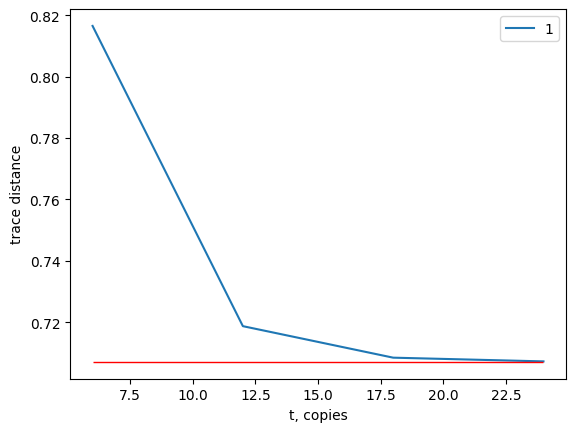

In [6]:


qubits=1
copies=[6,12,18,24]
test_ops=(X+ Z)/np.linalg.norm((X + Z),2)
data=[[],[]]
for copy in copies:
        #print("------ test for ",copy," coipes, operator ",T,"----------------\n\n embedded bosonic opeator:")
    A= build_embedded_matrix(test_ops,
                                 2**qubits,
                                 copy)
        #print(np.real(np.round(A,3)),"\n its spectral norm:",np.linalg.norm(A, ord=2))
    Convers= orbit_counting(copy,qubits,[6],False)[4]
        #print("conversion matrix:\n",np.round(Convers,2), "\n semi-orthogonal:",
        #        np.allclose(np.dot(Convers,Convers.T),np.eye(len(Convers)),rtol=1e-5))
    red=Convers@A@Convers.T
        #print("==> operator in reduced basis: \n",np.real(np.round(red, 3)))
        #print("-------spectral norm of the reduced operator----:\n",np.linalg.norm(red, ord=2))
    data[0].append(copy)
    data[1].append(np.linalg.norm(red, ord=2))
plt.plot(data[0],data[1])
plt.ylabel("trace distance")
plt.xlabel("t, copies")
plt.legend('1-')
plt.hlines(y=1/2**0.5, xmin=6, xmax=24, linewidth=1, color='r', label=('sqrt(1/2)- expected limit'))
plt.savefig('1_qubit_direction_X+Z.pdf')
#print(test_ops[T])

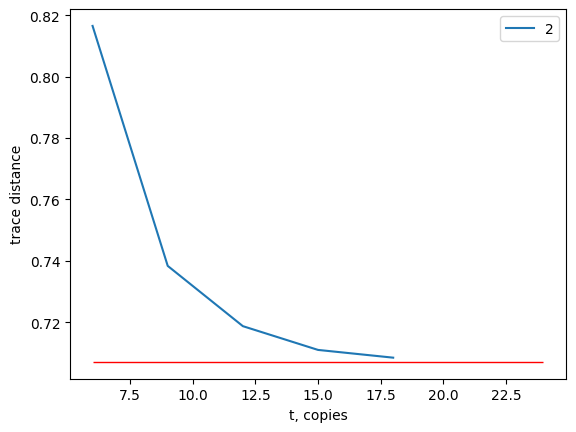

In [7]:
qubits=2
copies=[6,9,12,15,18]
test_ops=(M["XI"]+ M["ZX"])/np.linalg.norm((M["XI"]+ M["ZX"]),2)
data=[[],[]]
for copy in copies:
        #print("------ test for ",copy," coipes, operator ",T,"----------------\n\n embedded bosonic opeator:")
    A= build_embedded_matrix(test_ops,
                                 2**qubits,
                                 copy)
        #print(np.real(np.round(A,3)),"\n its spectral norm:",np.linalg.norm(A, ord=2))
    Convers= orbit_counting(copy,qubits,[6],False)[4]
        #print("conversion matrix:\n",np.round(Convers,2), "\n semi-orthogonal:",
        #        np.allclose(np.dot(Convers,Convers.T),np.eye(len(Convers)),rtol=1e-5))
    red=Convers@A@Convers.T
        #print("==> operator in reduced basis: \n",np.real(np.round(red, 3)))
        #print("-------spectral norm of the reduced operator----:\n",np.linalg.norm(red, ord=2))
    data[0].append(copy)
    data[1].append(np.linalg.norm(red, ord=2))
plt.plot(data[0],data[1])
plt.ylabel("trace distance")
plt.xlabel("t, copies")
plt.legend('2 qubit, direction XI+ZX') 
plt.savefig('2_qubit_direction_XI+ZX.pdf')
plt.hlines(y=1/2**0.5, xmin=6, xmax=24, linewidth=1, color='r', label=('sqrt(1/2)- expected limit'))
#print(test_ops[T])

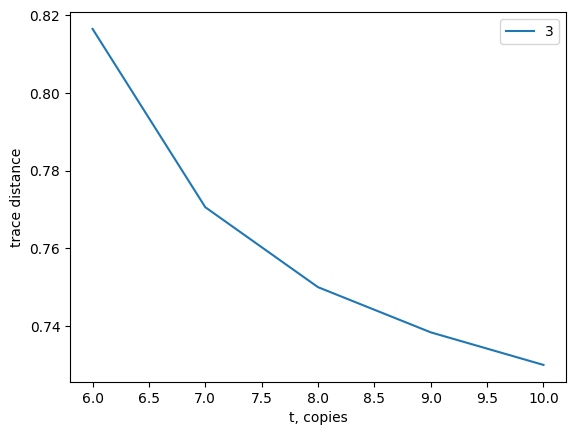

In [4]:
#running test on 3 qubits for operator xxx+zzz

qubits=3
copies=[6,7,8,9,10]
test_ops=( np.kron(X,M['XX'])+ np.kron(Z,M['ZZ']))/np.linalg.norm(( np.kron(X,M['XX'])+ np.kron(Z,M['ZZ'])),2)
data=[[],[]]
for copy in copies:
        #print("------ test for ",copy," coipes, operator ",T,"----------------\n\n embedded bosonic opeator:")
    A= build_embedded_matrix(test_ops,
                                 2**qubits,
                                 copy)
        #print(np.real(np.round(A,3)),"\n its spectral norm:",np.linalg.norm(A, ord=2))
    Convers= orbit_counting(copy,qubits,[6],False)[4]
        #print("conversion matrix:\n",np.round(Convers,2), "\n semi-orthogonal:",
        #        np.allclose(np.dot(Convers,Convers.T),np.eye(len(Convers)),rtol=1e-5))
    red=Convers@A@Convers.T
        #print("==> operator in reduced basis: \n",np.real(np.round(red, 3)))
        #print("-------spectral norm of the reduced operator----:\n",np.linalg.norm(red, ord=2))
    data[0].append(copy)
    data[1].append(np.linalg.norm(red, ord=2))
plt.plot(data[0],data[1])
plt.ylabel("trace distance")
plt.xlabel("t, copies")
plt.legend('3 qubits, direction XXX+ZZZ')
plt.savefig('3qubit-direction_XXX+ZZZ.pdf')
#print(test_ops[T])

In [5]:
#running test on 3 qubits for operator xxx+zzz

qubits=3
copies=[6,7,8,9,10,11]
test_ops=( np.kron(X,M['XX'])+ np.kron(Z,M['ZZ']))/np.linalg.norm(( np.kron(X,M['XX'])+ np.kron(Z,M['ZZ'])),2)
data=[[],[]]
for copy in copies:
        #print("------ test for ",copy," coipes, operator ",T,"----------------\n\n embedded bosonic opeator:")
    A= build_embedded_matrix(test_ops,
                                 2**qubits,
                                 copy)
        #print(np.real(np.round(A,3)),"\n its spectral norm:",np.linalg.norm(A, ord=2))
    Convers= orbit_counting(copy,qubits,[6],False)[4]
        #print("conversion matrix:\n",np.round(Convers,2), "\n semi-orthogonal:",
        #        np.allclose(np.dot(Convers,Convers.T),np.eye(len(Convers)),rtol=1e-5))
    red=Convers@A@Convers.T
        #print("==> operator in reduced basis: \n",np.real(np.round(red, 3)))
        #print("-------spectral norm of the reduced operator----:\n",np.linalg.norm(red, ord=2))
    data[0].append(copy)
    data[1].append(np.linalg.norm(red, ord=2))
plt.plot(data[0],data[1])
plt.ylabel("trace distance")
plt.xlabel("t, copies")
plt.legend('3 qubits, direction XXX+ZZZ')
plt.savefig('3qubit-direction_XXX+ZZZ.pdf')
#print(test_ops[T])

MemoryError: Unable to allocate 15.1 GiB for an array with shape (31824, 31824) and data type complex128

sweep tests:

In [7]:
H = np.sin(np.pi/4) * np.kron(X, M['XX']) + np.cos(np.pi/4) * np.kron(Z, M['ZZ'])

8

In [ ]:
# ---------- 3 qubits: H(θ) = sinθ * (X⊗XX) + cosθ * (Z⊗ZZ) ----------
# Assumes X, Z, and M dict (with M['XX'], M['ZZ']) are already defined as in your first cell.

n_qubits = 3
t_list_3q = [6]          # adjust as needed, e.g. [6, 12, 18]
angles = np.linspace(0, 0.5*np.pi, 20)

plt.figure(figsize=(6, 6))
for t in t_list_3q:
    # one-time setup per (n, t)
    orbits, C, prob, Hpar, Xvar, basis, basis_dict = split_convex_setup(
        block_qubits=n_qubits, multiplier=t, Verbose=False, Antiid_dim_set=[6], complexity=True
    )

    curve_x, curve_z = [], []
    for ang in angles:
        # single-copy 3-qubit operator: 8x8
        W1 = np.kron(X, M['XX'])   # X on qubit-1, XX on qubits-2&3
        W2 = np.kron(Z, M['ZZ'])   # Z on qubit-1, ZZ on qubits-2&3
        H  = np.sin(ang) * W1 + np.cos(ang) * W2

        # solve reduced SDP for this direction
        sol, rho_r = split_convex_run(
            initstate=H,
            conversion_matrix=C,
            problemo=prob,
            parametero=Hpar,
            variableo=Xvar,
            block_qubits=n_qubits,
            multiplier=t,
            Verbose=False,
        )

        # 1-copy reduced density matrix (8x8 for 3 qubits)
        rho1 = construct_reduced_density_2(rho_r, C, basis, basis_dict, copies=t)

        # projections onto the two sweep directions
        curve_x.append(np.real(np.trace(W1 @ rho1)))
        curve_z.append(np.real(np.trace(W2 @ rho1)))

    plt.plot(curve_x, curve_z, marker='.', label=f"t={t}")

plt.axis('equal')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.xlabel(r"$\langle X\otimes X\otimes X \rangle$"); plt.ylabel(r"$\langle Z\otimes Z\otimes Z \rangle$")
plt.title("3-qubit sweep: H(θ) = sinθ·(X⊗XX) + cosθ·(Z⊗ZZ)")
plt.legend()
plt.tight_layout()
plt.savefig("sweep_3q_X-XX__Z-ZZ.pdf")
plt.show()


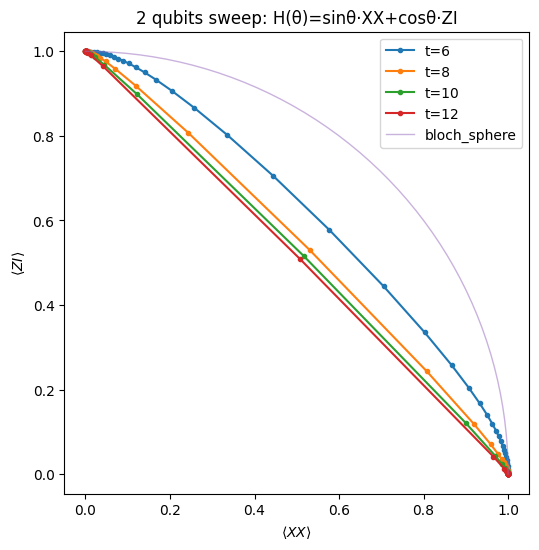

In [13]:
# ---------- 2 qubits: choose H(θ) = sinθ·(X⊗X) + cosθ·(Z⊗I) ----------
t_list_2q = [6, 8, 10, 12]
XX = np.kron(X, X)
ZI = np.kron(Z, I)

angles = np.linspace(0, np.pi/2, 41)

plt.figure(figsize=(6,6))
for t in t_list_2q:
    # one-time setup per t
    orbits, C, prob, Hpar, Xvar, basis, basis_dict = split_convex_setup(
        block_qubits=2, multiplier=t, Verbose=False, Antiid_dim_set=[6], complexity=True
    )

    curve_xx, curve_zi = [], []
    for ang in angles:
        H = np.sin(ang) * XX + np.cos(ang) * ZI
        sol, rho_red = split_convex_run(
            initstate=H,
            conversion_matrix=C,
            problemo=prob,
            parametero=Hpar,
            variableo=Xvar,
            block_qubits=2,
            multiplier=t,
            Verbose=False,
        )
        # 1-copy reduced density matrix (4x4 for 2 qubits)
        rho1 = construct_reduced_density_2(rho_red, C, basis, basis_dict, copies=t)

        curve_xx.append(np.real(np.trace(XX @ rho1)))
        curve_zi.append(np.real(np.trace(ZI @ rho1)))

    plt.plot(curve_xx, curve_zi, marker='.', label=f"t={t}")

ang_ref = np.linspace(0, 0.5*np.pi, 50)
plt.plot(np.cos(ang_ref), np.sin(ang_ref), lw=1, alpha=0.5, label="bloch_sphere")
plt.axis('equal'); plt.xlim(-0.05, 1.05); plt.ylim(-0.05, 1.05)
plt.xlabel(r"$\langle XX \rangle$"); plt.ylabel(r"$\langle ZI \rangle$")
plt.title("2 qubits sweep: H(θ)=sinθ·XX+cosθ·ZI")
plt.legend(); plt.show()

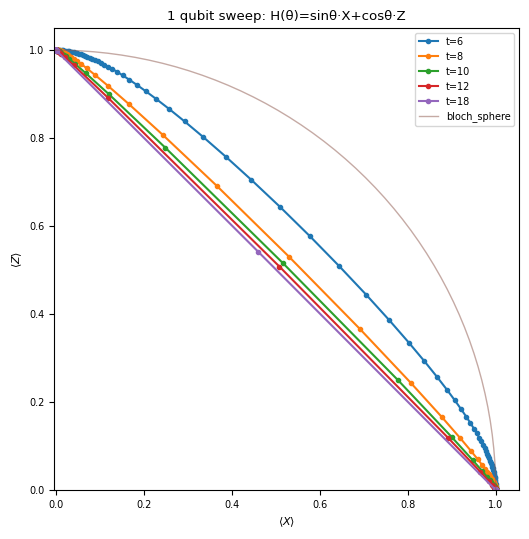

In [30]:
# ---------------- 1 qubit: H(θ)=sinθ·X + cosθ·Z ----------------
t_list_1q = [6, 8, 10, 12, 18]
angles = np.linspace(0, np.pi*0.5, 81)

plt.figure(figsize=(6,6))
for t in t_list_1q:
    # orbit basis + precompute Q for fast reduced ops
    comps, basis, basis_dict, C = orbit_counting_fast(t_factor=t, block_qubits=1, AId_dim_set=[6], verbose=False)
    assert check_C_orthonormal(C)
    Q = precompute_Q(block_qubits=1, t_factor=t, C=C, basis=basis, basis_dict=basis_dict)

    # pre-build reduced Pauli ops
    HrX = reduced_from_Q(X, Q).toarray()
    HrZ = reduced_from_Q(Z, Q).toarray()

    # SDP once per t with warm starts
    R = C.shape[0]
    prob, Hpar, Xvar = setup_reduced_sdp(R, complex_var=False)

    curve_x, curve_z = [], []
    for k, ang in enumerate(angles):
        Hpar.value = np.sin(ang)*HrX + np.cos(ang)*HrZ
        prob.solve(solver=cp.SCS, eps=1e-4, max_iters=10000, warm_start=(k>0), verbose=False)

        rho_red = Xvar.value
        rho1 = rdm1_from_reduced(rho_red, Q, t)

        curve_x.append(np.real(np.trace(X @ rho1)))
        curve_z.append(np.real(np.trace(Z @ rho1)))

    plt.plot(curve_x, curve_z, marker='.', label=f"t={t}")

# reference Bloch circle
ang_ref = np.linspace(0, 2*np.pi, 200)
plt.plot(np.cos(ang_ref), np.sin(ang_ref), lw=1, alpha=0.5, label="bloch_sphere")

plt.axis('equal'); plt.xlim(-0.00, 1.05); plt.ylim(-0.00, 1.05)
plt.xlabel(r"$\langle X \rangle$"); plt.ylabel(r"$\langle Z \rangle$")
plt.title("1 qubit sweep: H(θ)=sinθ·X+cosθ·Z")
plt.legend(); plt.savefig('sweep_1q_XZ.pdf')

c:\Users\mmlob\Desktop\progs\Main\.venv\lib\site-packages\cvxpy\cvxcore\python\canonInterface.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  param_vec[col:col + size] = value


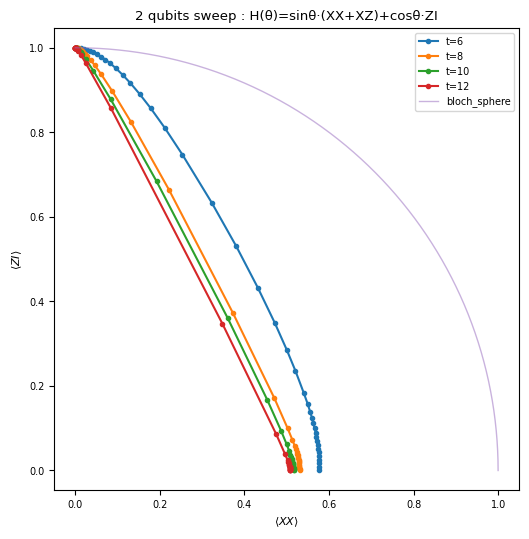

In [32]:
# ---------------- 2 qubits: H(θ)=sinθ·(XX+XZ) + cosθ·ZI ----------------
t_list_2q = [6, 8, 10, 12]
XX = np.kron(X, X)
XZ = np.kron(X, Z)
ZI = np.kron(Z, I)

angles = np.linspace(0, np.pi/2, 41)

plt.figure(figsize=(6,6))
for t in t_list_2q:
    comps, basis, basis_dict, C = orbit_counting_fast(t_factor=t, block_qubits=2, AId_dim_set=[6], verbose=False)
    assert check_C_orthonormal(C)
    Q = precompute_Q(block_qubits=2, t_factor=t, C=C, basis=basis, basis_dict=basis_dict)

    HrXX = reduced_from_Q(XX, Q).toarray()
    HrXZ = reduced_from_Q(XZ, Q).toarray()
    HrZI = reduced_from_Q(ZI, Q).toarray()

    R = C.shape[0]
    prob, Hpar, Xvar = setup_reduced_sdp(R, complex_var=False)

    curve_xx, curve_zi = [], []
    for k, ang in enumerate(angles):
        Hpar.value = np.sin(ang)*(HrXX + HrXZ) + np.cos(ang)*HrZI
        prob.solve(solver=cp.SCS, eps=1e-4, max_iters=10000, warm_start=(k>0), verbose=False)

        rho_red = Xvar.value
        rho1 = rdm1_from_reduced(rho_red, Q, t)

        curve_xx.append(np.real(np.trace(XX @ rho1)))
        curve_zi.append(np.real(np.trace(ZI @ rho1)))

    plt.plot(curve_xx, curve_zi, marker='.', label=f"t={t}")
# reference Bloch circle
ang_ref = np.linspace(0, 0.5*np.pi, 200)
plt.plot(np.cos(ang_ref), np.sin(ang_ref), lw=1, alpha=0.5, label="bloch_sphere")

plt.axis('equal'); plt.xlim(-0.05, 1.05); plt.ylim(-0.05, 1.05)
plt.xlabel(r"$\langle XX \rangle$"); plt.ylabel(r"$\langle ZI \rangle$")
plt.title("2 qubits sweep : H(θ)=sinθ·(XX+XZ)+cosθ·ZI")
plt.legend(); plt.savefig("sweep-2q_xx_zz--ZI.pdf")